In [2]:
import gymnasium
from gymnasium import error, spaces, utils, Env
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Descripción del problema

El siguiente ejemplo consiste en un Ambiente (Room). La temperatura de la habitación cambia debido a la temperatura externa ambiente (se asume de forma desconocida). La habitación cuenta con un equipo de Aire Acondicionado controlado por un Agente. El objetivo de este Agente es mantener la temperatura en 0 grados. El Aire Acondicionado puede cambiar la temperatura en 0, 1, 2 o 3 grados ya sea frío o calor.

# Ambiente

El ambiente (Room) está simulado por el siguiente código

In [3]:
class Room(Env):
    
    def __init__(self):
        self.observation_space = spaces.Box(low=-20, high=40, shape=(), dtype=np.float32)
        self.action_space = spaces.Discrete(7, start=-3)
                  
    def reset(self):
        self.step_count = 0
        self.initial_random = self.observation_space.sample()
        self.external_temp = 0
        self.external_temp = self._temp_variation()
        self.temp = self.external_temp
        return self.temp
    
    def step(self, action):
        delta_temp = self._temp_variation()
        self.external_temp += delta_temp
        self.temp += delta_temp + action
        self.step_count += 1
        return self.temp

    def _temp_variation(self):
        x = self.initial_random + self.step_count
        return np.float64('%.2f'%(20 * np.sin(x/10))) - self.external_temp 
          

# Test Room

In [4]:
env = Room()

In [5]:
env.observation_space

Box(-20.0, 40.0, (), float32)

In [6]:
env.observation_space.sample()

array(21.999, dtype=float32)

In [7]:
env.action_space

Discrete(7, start=-3)

In [8]:
env.action_space.sample()

np.int64(3)

In [9]:
env.reset()

np.float64(-13.52)

# Reflex Agent

Esta es la implementación de un Agente Reflejo Simple, que dada la observación (temperatura de la habitación), toma una acción de enfriar o calentar en 0, 1, 2 o 3 grados. El agente solo enfría o calienta si la temperatura difiere en más de 2 grados.

In [10]:
class AgentReflex():

    def lookup(self, obs):
        if obs > 9:
            return -3
        elif obs > 5:
            return -2
        elif obs > 2:
            return -1
        elif obs < -9:
            return 3
        elif obs < -5:
            return 2
        elif obs < -2:
            return 1
        else:
            return 0

# Test Reflex

In [11]:
agent = AgentReflex()

In [12]:
obs = env.reset()
external_res = []
agent_res = []
total_steps = 100

In [13]:
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = agent.lookup(obs)
    obs = env.step(action)
    agent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

External: 18.07 
 Prev. Obs: 18.07 -> Action: -3 -> Room: 15.07
External: 18.07 
 Prev. Obs: 15.07 -> Action: -3 -> Room: 11.129999999999999
External: 17.13 
 Prev. Obs: 11.129999999999999 -> Action: -3 -> Room: 7.010000000000002
External: 16.01 
 Prev. Obs: 7.010000000000002 -> Action: -2 -> Room: 3.74
External: 14.74 
 Prev. Obs: 3.74 -> Action: -1 -> Room: 1.3100000000000005
External: 13.31 
 Prev. Obs: 1.3100000000000005 -> Action: 0 -> Room: -0.2400000000000002
External: 11.76 
 Prev. Obs: -0.2400000000000002 -> Action: 0 -> Room: -1.92
External: 10.08 
 Prev. Obs: -1.92 -> Action: 0 -> Room: -3.6899999999999995
External: 8.31 
 Prev. Obs: -3.6899999999999995 -> Action: 1 -> Room: -4.55
External: 6.45 
 Prev. Obs: -4.55 -> Action: 1 -> Room: -5.47
External: 4.53 
 Prev. Obs: -5.47 -> Action: 2 -> Room: -5.4399999999999995
External: 2.56 
 Prev. Obs: -5.4399999999999995 -> Action: 2 -> Room: -5.43
External: 0.5699999999999998 
 Prev. Obs: -5.43 -> Action: 2 -> Room: -5.43
External:

# Graficando los resultados

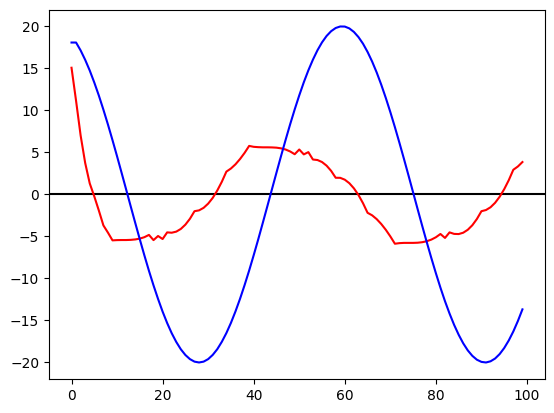

In [14]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), agent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente

# Métrica de Performance
Una posible métrica de performance, podría ser ver la temperatura media del ambiente con la acción del agente.

In [15]:
print("Temperatura media con el agente: ", np.mean(agent_res))
print("Temperatura media sin el agente: ", np.mean(external_res))

Temperatura media con el agente:  -0.5630999999999999
Temperatura media sin el agente:  -2.1109


Otra posible métrica de performance, es evaluar para cada instante de tiempo (step) cuanto difiere la temperatura obtenida de la objetivo=0. Esto se puede hacer con mean_squared_error o mean_absolute_error. 
Comparemos la métrica obtenida por el agente contra la métrica obtenida sin un agente:

In [16]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente: ", mean_absolute_error(goal_temp, agent_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res))

Variación media con el agente:  4.0121
Variación media sin el agente:  12.942100000000003


# Ejercicio: Model (Goal / Utility) Based Agent 

Construir un Agente basado en un modelo. 
Esto es: 
    - Construir un modelo a mano, por ejemplo un grafo, con estados y transiciones [Ver figura].
    - Discretizar las observaciones devueltas por el ambiente mapeándolas a un estado.
    - Tomar una decisón basada en el estado.
    - Definir un objetivo y una utilidad.

Por ejemplo, el Agente podría conocer un modelo que tiene 2 estados {Frío, Calor}
<img src="Modelo.png">


In [ ]:
from agent import Agent
import constants

# ¿Qué es el objetivo de este agente? --> Alcanzar y mantener el estado Confort.
class GoalBasedAgent(Agent):
    def __init__(self):
        self.states = [constants.COLD, constants.OK, constants.HOT]
        self.maxVariationPerAction = 3 # Puedo subir o bajar hasta 3 grados en una accion

    # Decidir una accion para interactuar con el entorno. Te pregunta que es lo que vas a hacer.
    def next_action(self, obs):
        # obs: medición de temperatura en grados Celsius.
        currentState = self.obsToState(obs)
        action = 0 # Dejar quieto como esta
        if currentState == constants.HOT:
            action = -1 * min(round(obs), self.maxVariationPerAction) # Enfriar
        elif currentState == constants.COLD:
            action = abs(max(round(obs), self.maxVariationPerAction * -1)) # Calentar
        return action

    # obsToState discretiza obs en estado
    def obsToState(self, obs):
        i = 1
        if obs > 1:
            i += 1
        elif obs < -1:
            i -= 1
        return self.states[i]

In [40]:
gbagent = GoalBasedAgent()

env = Room()

obs = env.reset()
external_res = []
gbagent_res = []
total_steps = 100

for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = gbagent.next_action(obs)
    obs = env.step(action)
    gbagent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

External: -14.99 
 Prev. Obs: -14.99 -> Action: 3 -> Room: -11.99
External: -14.99 
 Prev. Obs: -11.99 -> Action: 3 -> Room: -10.239999999999998
External: -16.24 
 Prev. Obs: -10.239999999999998 -> Action: 3 -> Room: -8.32
External: -17.32 
 Prev. Obs: -8.32 -> Action: 3 -> Room: -6.239999999999998
External: -18.24 
 Prev. Obs: -6.239999999999998 -> Action: 3 -> Room: -3.960000000000001
External: -18.96 
 Prev. Obs: -3.960000000000001 -> Action: 3 -> Room: -1.5
External: -19.5 
 Prev. Obs: -1.5 -> Action: 2 -> Room: 0.14999999999999858
External: -19.85 
 Prev. Obs: 0.14999999999999858 -> Action: 0 -> Room: 0.010000000000001563
External: -19.99 
 Prev. Obs: 0.010000000000001563 -> Action: 0 -> Room: 0.05999999999999872
External: -19.94 
 Prev. Obs: 0.05999999999999872 -> Action: 0 -> Room: 0.3099999999999987
External: -19.69 
 Prev. Obs: 0.3099999999999987 -> Action: 0 -> Room: 0.7600000000000016
External: -19.24 
 Prev. Obs: 0.7600000000000016 -> Action: 0 -> Room: 1.3999999999999986
E

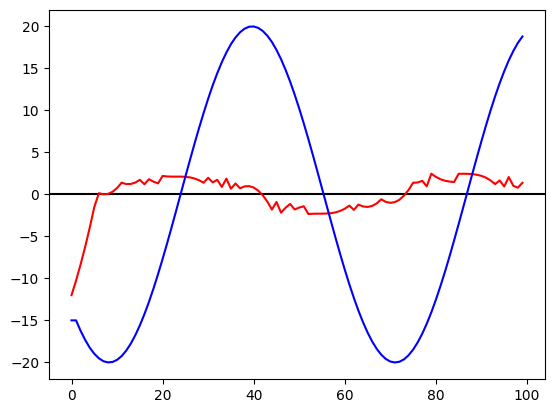

In [41]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), gbagent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente

In [42]:
print("Temperatura media con el agente: ", np.mean(gbagent_res))
print("Temperatura media sin el agente: ", np.mean(external_res))

Temperatura media con el agente:  0.029400000000000082
Temperatura media sin el agente:  -2.1344000000000003


In [43]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente: ", mean_absolute_error(goal_temp, gbagent_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res))

Variación media con el agente:  1.8084000000000002
Variación media sin el agente:  12.9592


# PENDIENTE HACERLO CON Utility Based Agent 